In [15]:
from typing import List, Tuple
import matplotlib.pyplot as plt
import numpy as np

# my custom style, if the PC has no latex you can comment it and use the default style of matplotlib
# but remove all latex labels in the code
plt.style.use('https://raw.githubusercontent.com/uhveg/matplotlibStyles/main/thesis.mplstyle')
prop_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
prop_cycle += prop_cycle

In [2]:
def csch(x:float) -> float:
    if x == 0:
        return float('inf')
    return 1 / np.sinh(x)

def acsch(x):
    return np.log(1/x + np.sqrt(1/x**2 + 1))

def signed_area(pi:np.ndarray, pj:np.ndarray, pk:np.ndarray) -> float:
        if len(pi.shape) < 2:
             pi, pj, pk = pi[:,np.newaxis], pj[:,np.newaxis], pk[:,np.newaxis]
        lij = pi[:2] - pj[:2]
        lik = pi[:2] - pk[:2]
        I = np.array([[0,1],[-1,0]])
        return (0.5 * lij.T @ I @ lik).item()

class znn:
    def __init__(self, k0:float, tau:float) -> None:
        self.tau = tau
        self.gamma = 1.0
        self.fk = 0
        self.fk_1 = 0
        self.k = k0
        self.KK = [k0]

    def updateK(self, f:float, t=0) -> float:
        self.fk_1 = self.fk
        self.fk = f
        # wait some time to start in the vicindity of Dij, (could be improved)
        if t > 15: 
            pDpK = self.partialD_partialK()
            kp = (self.gamma*self.tau*self.sigma(self.fk) + self.fk - self.fk_1)
            self.k += - kp / pDpK
        self.KK += [self.k]

    def partialD_partialK(self) -> float:
        return acsch(np.sqrt(self.k)) - 1 / (2*np.sqrt(self.k+1))

    def sigma(self, x:float) -> float:
        # Uncomment the next line to use a linear activation function
        # return x
        zeta = 1
        return 0.5*(np.exp(zeta*x) - np.exp(-zeta*x))

In [24]:
class Robot:
    def __init__(self, id:int, p0:np.array = np.zeros((2,1)), c:str = "#ff0000") -> None:
        self.position = p0 # x, y, theta ->
        self.dxy = np.zeros((2,1)) # zeros
        self.neighbors:List[List[Robot, float]] = []
        self.triplets:List[Tuple[int, int, float]] = []
        self.positions = np.copy(self.position)
        self.color = c
        self.id = id

    def updateK(self, K, j):
        assert self.has_neighbor(j)
        for i in range(len(self.neighbors)):
            if self.neighbors[i][0].id == j:
                self.neighbors[i][1] = K

    def link(self, rb:'Robot', k:float):
        self.neighbors.append([rb, k])
        rb.neighbors.append([self, k])
    
    def add_triplet(self, triplet:Tuple[int, int, float]):
        j, k = self.get_neighbor(triplet[0]), self.get_neighbor(triplet[1])
        if j is not None and k is not None:
            self.triplets.append(triplet)
            j.triplets.append((k.id, self.id, triplet[2]))
            k.triplets.append((self.id, j.id, triplet[2]))
        else:
            print("NOT NEIGHBOR")

    def get_neighbor(self, index:int) -> 'Robot | None':
        for n,_ in self.neighbors:
            if n.id == index:
                return n
        return None

    def has_neighbor(self, index:int) -> bool:
        for n,_ in self.neighbors:
            if n.id == index:
                return True
        return False
    
    def control_csch(self):
        if self.dxy is None:
            self.dxy = np.zeros((2,1))
        MM = 3.0
        alpha, delta = 1.0, 0.1
        U = np.zeros((2,1))
        for neigh in self.neighbors:
            k_g = neigh[1]
            l = self.position - neigh[0].position
            norm_l = np.linalg.norm(l)
            if norm_l <= 0:
                print(f"Error {self.id} - {neigh[0].id}")
            csch_ = csch((norm_l - delta) / k_g)
            w = alpha*(1 - (1/(k_g * norm_l))*csch_**2)
            U -= w*l
        self.dxy += U

    def control_sgd(self):
        if self.dxy is None:
            self.dxy = np.zeros((2,1))
        MM = 3.0
        Uci = np.zeros((2,1))
        K = 10.0
        I = np.array([[0,1],[-1,0]])
        for triplet in self.triplets:
            neigh_j = self.get_neighbor(triplet[0])
            neigh_k = self.get_neighbor(triplet[1])
            Z_STR = triplet[2]
            Z_ijk = signed_area(self.position, neigh_j.position, neigh_k.position)
            ljk = neigh_j.position[:2] - neigh_k.position[:2]
            Uci -= K*(Z_ijk - Z_STR) * I @ ljk
        self.dxy += Uci

    def agent_avoidance(self, robots:List['Robot']):
        d_sens, delta = 0.4, 0.1
        alpha, K = 1.0, 0.8
        if self.dxy is None:
            self.dxy = np.zeros((2,1))
        UO = np.zeros((2,1))
        for rob in robots:
            if rob.id != self.id and not self.has_neighbor(rob.id):
                l = self.position - rob.position
                norm_l = np.linalg.norm(l)
                if norm_l < d_sens:
                    csch_ = csch((norm_l - delta) / K)
                    w = alpha*(1 - (1/(K * norm_l))*csch_**2)
                    UO -= w*l
        self.dxy +=UO

    def update(self, dt:float):
        MX_SPEED = 3
        # Uncomment the next lines to simulate a saturation like in a real experiment
        # self.dxy[0][0] = MX_SPEED if self.dxy[0][0]>MX_SPEED else -MX_SPEED if self.dxy[0][0]<-MX_SPEED else self.dxy[0][0]
        # self.dxy[1][0] = MX_SPEED if self.dxy[1][0]>MX_SPEED else -MX_SPEED if self.dxy[1][0]<-MX_SPEED else self.dxy[1][0]
        self.position[0] += dt*self.dxy[0]
        self.position[1] += dt*self.dxy[1]
        self.positions = np.hstack((self.positions, self.position))
        self.dxy = None

    def get_plot(self) -> None:
        x_end = np.cos(self.position[2][0])
        y_end = np.sin(self.position[2][0])
        plt.plot(self.positions[0,:], self.positions[1,:], c=self.color)
        plt.plot(self.position[0], self.position[1], "*", c=self.color)

In [4]:
# Function to get the coords of a star figure, just used to calculate the desired values
def getStarCoords(d:float = 1.0) -> Tuple[np.ndarray, float]:
    th = np.pi/5
    D1 = 2*d*np.cos(th)
    D2 = 2*d*np.sin(th/2)
    coords_zero = [[0,0],
                   [d*np.sin(th/2)        , -d*np.cos(th/2)       ],
                   [D1*np.sin(3*th/2)     , -D1*np.cos(3*th/2)    ],
                   [(d+D2)*np.sin(th/2)   , -(d+D2)*np.cos(th/2)  ],
                   [(2*d+D2)*np.sin(th/2) , -(2*d+D2)*np.cos(th/2)],
                   [0                     , -(2*d+D2)*np.cos(th/2) + d*np.sin(th)],
                   [-(2*d+D2)*np.sin(th/2), -(2*d+D2)*np.cos(th/2)],
                   [-(d+D2)*np.sin(th/2)  , -(d+D2)*np.cos(th/2)  ],
                   [-D1*np.sin(3*th/2)    , -D1*np.cos(3*th/2)    ],
                   [-d*np.sin(th/2)       , -d*np.cos(th/2)       ]]
    return np.array(coords_zero).T, D2*d*np.cos(th/2)/2

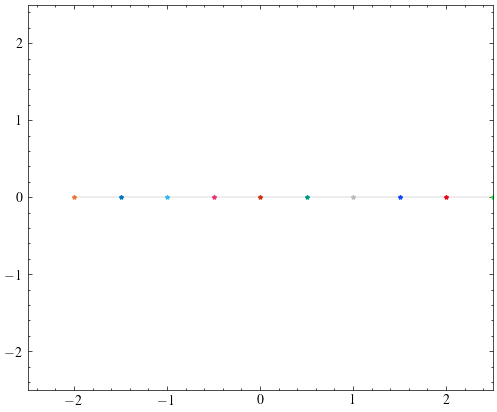

In [16]:
coords, singleArea = getStarCoords()
coords = np.array([[-2+i*0.5,0] for i in range(10)]).T

plt.plot(coords[0,:], coords[1,:], linewidth=0.3, color="#aaaaaa")
for i in range(coords.shape[1]):
    plt.plot(coords[0,i], coords[1,i], marker='*')
plt.xlim((-2.5, 2.5))
plt.ylim((-2.5, 2.5))
plt.show()

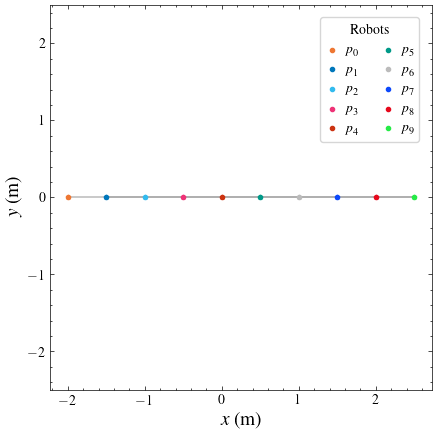

In [25]:
all_rbts:List[Robot] = [Robot(i, np.copy(coords[:,[i]])) for i in range(coords.shape[1])]

# create connections and desired values
edges = [(i,i+1,1.0) for i in range(9)]
edges += [(5,1,1.0),(5,9,1.0),(9,0,1.0),(1,3,0.618),(3,5,0.618),(5,7,0.618),(7,9,0.618),(9,1,0.618)]
areas = [(0,9,1,singleArea)] + [(i,i-1,i+1,singleArea) for i in range(2,9,2)] + [(3,1,5,0.182),(5,1,9,singleArea),(7,5,9,0.182)]

ZNN:list[znn] = []
## EDGES
x = [0.85176409, 0.25178205]
for i in range(12):
    all_rbts[edges[i][0]].link(all_rbts[edges[i][1]], x[0])
    ZNN += [znn(x[0], 0.01)]
for i in range(12,len(edges)):
    all_rbts[edges[i][0]].link(all_rbts[edges[i][1]], x[1])
    ZNN += [znn(x[1], 0.01)]

## AREAS
for a in areas:
    all_rbts[a[0]].add_triplet((a[1],a[2],a[3]))

fig, ax = plt.subplots()
ax: plt.Axes

for i in range(len(all_rbts)):
    color = prop_cycle[i]
    ax.scatter(all_rbts[i].positions[0,0], all_rbts[i].positions[1,0], color=color, marker="*", zorder=2)
    ax.plot(all_rbts[i].positions[0,:], all_rbts[i].positions[1,:], color=color, linestyle="-", zorder=2)
    ax.scatter(all_rbts[i].positions[0,-1], all_rbts[i].positions[1,-1], color=color, marker="o",label=rf"$p_{all_rbts[i].id}$", zorder=2)
    for neigh in all_rbts[i].neighbors:
        ax.plot([all_rbts[i].position[0],neigh[0].position[0]], [all_rbts[i].position[1],neigh[0].position[1]], linewidth=0.3, color="#aaaaaa", zorder=1)

plt.legend(title="Robots", ncol=2)
ax.set_xlabel(r"$x$ (m)")
ax.set_ylabel(r"$y$ (m)")
# ax.set_xlim((-2.5, 2.5))
ax.set_ylim((-2.5, 2.5))
ax.set_aspect("equal")
# plt.savefig('images/turtle_amb_csch__.pdf')
plt.show()

In [26]:
# simple simulation based on euler integration
# choose to use znn to adjust the gains in real time or not
USE_ZNN = True

t, dt = 0, 0.01
while t < 50:
    if USE_ZNN:
        for i, e in enumerate(edges):
            all_rbts[e[0]].updateK(ZNN[i].k, e[1])
            all_rbts[e[1]].updateK(ZNN[i].k, e[0])

    t += dt
    for i in range(len(all_rbts)):
        all_rbts[i].control_csch()
        all_rbts[i].control_sgd()
        all_rbts[i].agent_avoidance(all_rbts)
    
    if USE_ZNN:
        for i, e in enumerate(edges):
            lij = all_rbts[e[0]].position - all_rbts[e[1]].position
            nlij = np.linalg.norm(lij)
            ZNN[i].updateK(nlij - e[2], t)

    for i in range(len(all_rbts)):
        all_rbts[i].update(dt)

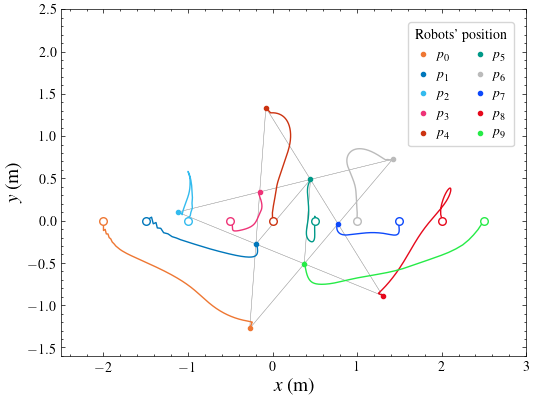

In [27]:
fig, ax = plt.subplots()
ax: plt.Axes

for i in range(len(all_rbts)):
    color = prop_cycle[i]
    ax.scatter(all_rbts[i].positions[0,0], all_rbts[i].positions[1,0], facecolor="white", edgecolor=color, marker="o", zorder=3, s=30)
    ax.plot(all_rbts[i].positions[0,:], all_rbts[i].positions[1,:], color=color, linestyle="-", zorder=2)
    ax.scatter(all_rbts[i].positions[0,-1], all_rbts[i].positions[1,-1], color=color, marker="o",label=rf"$p_{all_rbts[i].id}$", zorder=2)
    for neigh in all_rbts[i].neighbors:
        ax.plot([all_rbts[i].position[0],neigh[0].position[0]], [all_rbts[i].position[1],neigh[0].position[1]], linewidth=0.3, color="#aaaaaa", zorder=1)

plt.legend(title="Robots' position", ncol=2)
ax.set_xlabel(r"$x$ (m)")
ax.set_ylabel(r"$y$ (m)")
ax.set_xlim((-2.5, 3.0))
ax.set_ylim((-1.6, 2.5))
ax.set_aspect("equal")
# plt.savefig('images/znn_trajectory.pdf')
plt.show()

In [21]:
# Variables used for plotting
EDGES = dict()
EDGES_err = dict()
for e in edges:
    link = f"{e[0]}{e[1]}"
    EDGES[link] = np.linalg.norm(all_rbts[e[0]].positions - all_rbts[e[1]].positions, axis=0)
    EDGES_err[link] = EDGES[link] - e[2]
            
AREAS = dict()
AREAS_err = dict()
for triplet in areas:
    tri_str = f"{triplet[0]}{triplet[1]}{triplet[2]}"
    PI, PJ, PK = all_rbts[triplet[0]].positions.T, all_rbts[triplet[1]].positions.T, all_rbts[triplet[2]].positions.T
    AREAS[tri_str] = np.array([signed_area(pi, pj, pk) for pi, pj, pk in zip(PI,PJ,PK)])
    AREAS_err[tri_str] = AREAS[tri_str] - triplet[3]

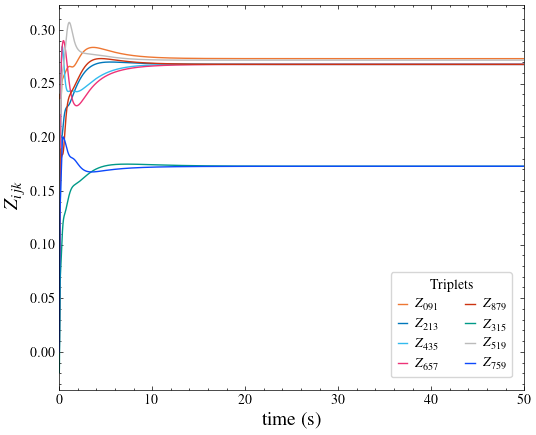

In [23]:
# Areas error
fig, ax = plt.subplots()
ax: plt.Axes
for i, a in enumerate(AREAS.keys()):
    ax.plot(np.linspace(0,t,AREAS[a].size), AREAS[a], prop_cycle[i], label=f"$Z_{{{a}}}$")
ax.set_xlabel(r"time (s)")
ax.set_ylabel(r"$Z_{ijk}$")
ax.set_xlim((0,t))
# ax.set_title("Signed Area")
plt.legend(title="Triplets", ncol=2, loc='lower right')
# plt.savefig('images/znn_areas.pdf')
plt.show()

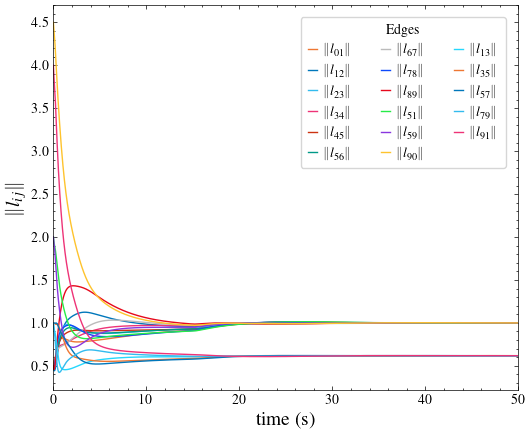

In [17]:
# Edge length errors
fig, ax = plt.subplots()
ax: plt.Axes
for i, e in enumerate(EDGES.keys()):
    ax.plot(np.linspace(0,t,EDGES[e].size), EDGES[e], prop_cycle[i], label=fr"$\lVert l_{{{e}}} \rVert$")
ax.set_xlabel(r"time (s)")
ax.set_ylabel(r"$\lVert l_{ij} \rVert$")
ax.set_xlim((0,t))
# ax.set_title("Robots' distance")
plt.legend(title="Edges", ncol=3)
# plt.savefig('images/znn_edges.pdf')
plt.show()

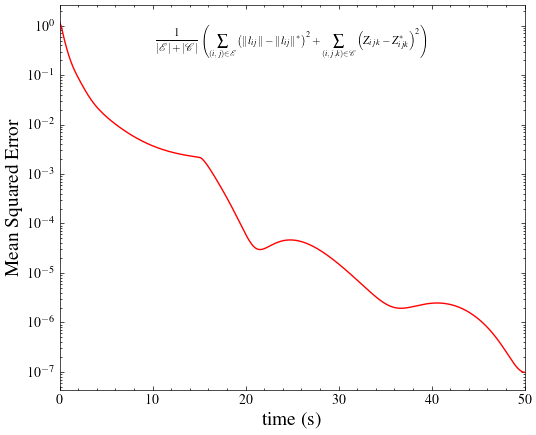

In [245]:
# MSE 
fig, ax = plt.subplots()
ax: plt.Axes
MSE = np.zeros((len(EDGES_err['01']),))
# MSE = np.zeros((len(EDGES_err[e]),))
for e in EDGES_err.keys():
    MSE += EDGES_err[e]**2
for a in AREAS_err.keys():
    MSE += AREAS_err[a]**2
MSE /= len(EDGES_err.keys()) + len(AREAS_err.keys())
ax.plot(np.linspace(0,t,len(MSE)), MSE, color='red')
ax.set_xlabel(r"time (s)")
# ax.set_ylabel(r"$\lVert l_{ij} \rVert$")
ax.set_xlim((0,t))
ax.set_ylabel("Mean Squared Error")
plt.yscale('log')
plt.text(0.5, 0.95, r"$\displaystyle \frac{1}{|\mathcal E|+|\mathcal C|}\left( \sum_{(i,j)\in \mathcal E}\left ( \lVert l_{ij} \rVert - \lVert l_{ij} \rVert^* \right )^2 + \sum_{(i,j,k)\in \mathcal C} \left ( Z_{ijk} -  Z_{ijk}^* \right )^2\right)$", horizontalalignment='center', verticalalignment='top', transform=ax.transAxes)
plt.savefig('images/znn_mse.pdf')
plt.show()

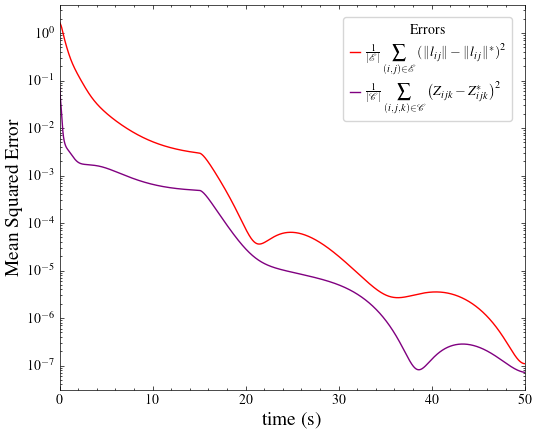

In [244]:
# MSE 
fig, ax = plt.subplots()
ax: plt.Axes
MSE_e = np.zeros((len(EDGES_err[list(EDGES_err.keys())[0]]),))
MSE_a = np.zeros((len(AREAS_err[list(AREAS_err.keys())[0]]),))
for e in EDGES_err.keys():
    MSE_e += EDGES_err[e]**2
for a in AREAS_err.keys():
    MSE_a += AREAS_err[a]**2
MSE_e /= len(EDGES_err.keys())
MSE_a /= len(AREAS_err.keys())
ax.plot(np.linspace(0,t,len(MSE_e)), MSE_e, color='red', label=r"$\displaystyle \tfrac{1}{|\mathcal E|}\sum_{(i,j)\in \mathcal E} \left ( \lVert l_{ij} \rVert - \lVert l_{ij} \rVert^* \right )^2$")
ax.plot(np.linspace(0,t,len(MSE_a)), MSE_a, color='purple', label=r"$\displaystyle \tfrac{1}{|\mathcal C|}\sum_{(i,j,k)\in \mathcal C} \left ( Z_{ijk} -  Z_{ijk}^* \right )^2$")
ax.set_xlabel(r"time (s)")
# ax.set_ylabel(r"$\lVert l_{ij} \rVert$")
ax.set_xlim((0,t))
ax.set_ylabel("Mean Squared Error")
plt.yscale('log')
plt.legend(title="Errors")
plt.savefig('images/znn_mse_sep.pdf')
plt.show()

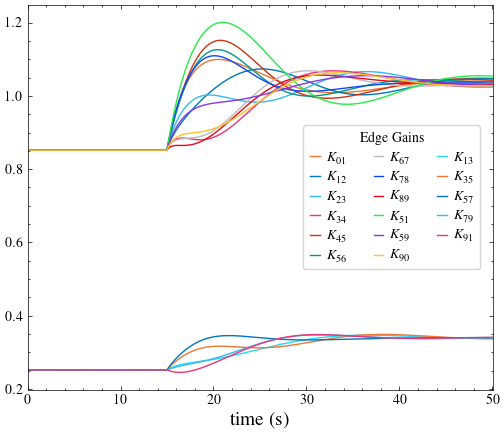

In [243]:
# MSE 
fig, ax = plt.subplots()
ax: plt.Axes
for z, e in zip(ZNN, edges):
    yvals = np.array(z.KK)
    ax.plot(np.linspace(0,t,len(yvals)), yvals, label=rf"$K_{{{e[0]}{e[1]}}}$")
ax.set_xlabel(r"time (s)")
# ax.set_ylabel(r"$\lVert l_{ij} \rVert$")
ax.set_xlim((0,t))
# ax.set_ylabel("Mean Squared Error")
# plt.yscale('log')
plt.legend(title="Edge Gains", ncols=3)
plt.savefig('images/znn_gains.pdf')
plt.show()